<a href="https://colab.research.google.com/github/TAUforPython/diffusion-neural-networks/blob/main/example%20Diffusion%20forward%20and%20reverse%20processs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DPM Forward and Reverse Process Demonstration
# This notebook demonstrates the forward process of a Diffusion Probabilistic Model (DPM) and a conceptual visualization of the learned reverse process.

q0t(xt|x0) = N(xt|α(t)x0, σ²(t)I) (Eq 1):

This defines the distribution of the state xt at time t, given the initial state x0. The code implements this by calculating x_t = sqrt(α_bar_t) * x0 + sqrt(1 - α_bar_t) * noise. Here, sqrt(α_bar_t) * x0 is the signal part (α(t)x0) and sqrt(1 - α_bar_t) * noise is the noise part (σ²(t)I for the variance).
Noise Schedule: The get_alpha_bar_t(t) function defines the cumulative noise schedule ᾱ(t) (or α_bar_t). This schedule determines how quickly the signal fades and the noise dominates. The paper mentions ᾱ(t) is related to the Signal-to-Noise Ratio (SNR), which is ᾱ(t) / (1 - ᾱ(t)). As t increases, ᾱ(t) decreases, making the SNR smaller.
Forward Process: The loop iterating t from 1 to T simulates the forward process. At each step, it samples from the Gaussian distribution defined by Eq. 1.
Purpose: This forward process is the definition of the DPM. It's not typically run as an inference algorithm itself, but it defines the problem. The goal of DPMs is to learn the reverse process (from xT back to x0), which involves learning the score function ∇x log q(xt, t) (related to ϵθ(xt, t) in the paper) to iteratively denoise the data. The provided DPM-Solver code in the document is for this reverse process. This notebook focuses on the forward process as requested.

--- DPM Forward Process Demonstration ---
This process shows how real data is converted into Gaussian noise using a schedule.

Original 'Real' Data (x0) - This remains constant:
[0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]

Simulating Forward Process (x0 -> xT)...
Signal-to-Noise Ratio (SNR = α_t² / σ_t²) at key timesteps:
  t=   1: SNR = 5083.225
  t= 250: SNR = 5.531
  t= 500: SNR = 0.975
  t= 750: SNR = 0.169
  t=1000: SNR = 0.000

--- Visualizing the Reverse Process using DPM-Solver-1 ---
This demonstrates the DPM-Solver ODE for denoising.
It assumes a perfect noise prediction model ϵθ for visualization.

Simulating Reverse Process (xT -> x0) using DPM-Solver-1:
  Reversing from t~1000 -> t~ 800 (DPM-Solver-1 update)
  Reversing from t~ 800 -> t~ 600 (DPM-Solver-1 update)
  Reversing from t~ 600 -> t~ 400 (DPM-Solver-1 update)
  Reversing from t~ 400 -> t~ 200 (DPM-Solver-1 update)
  Reversing from t~ 200 -> t~   0 (DPM-Solver-1 update)


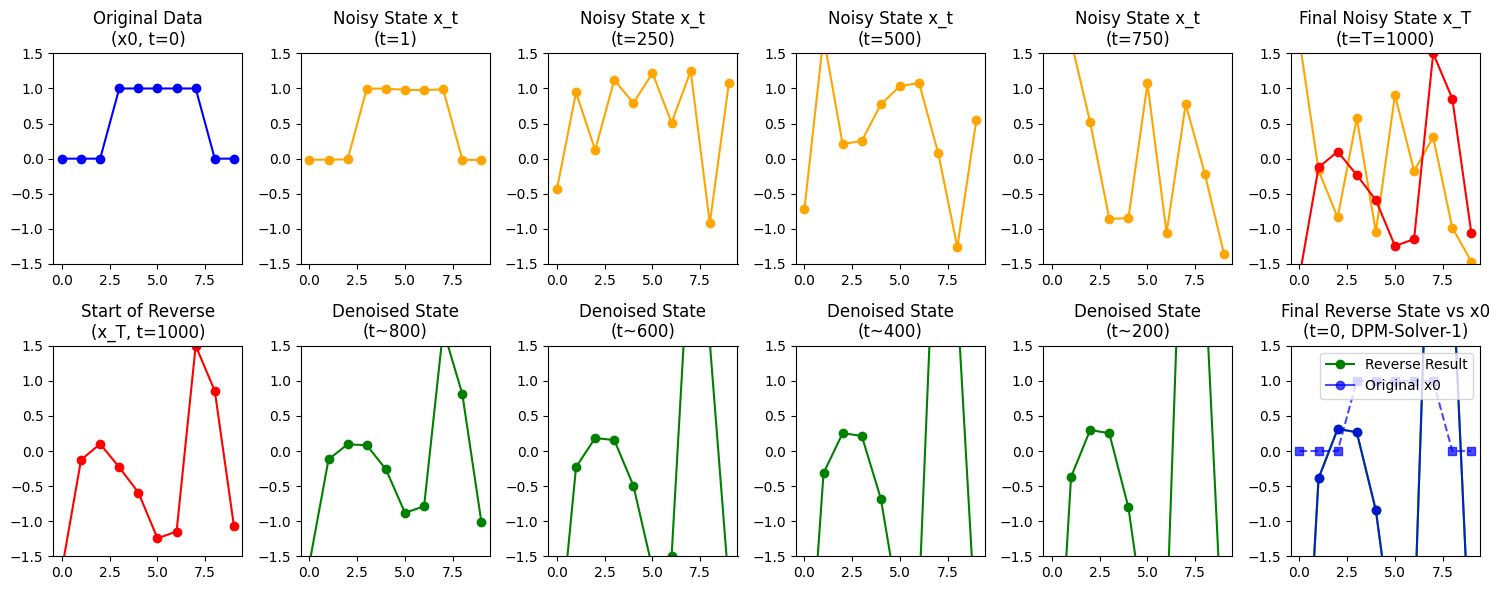


--- Explanation of the Processes ---
Forward Process (Top Row):
1. Defines the DPM: q0t(xt|x0) = N(xt|α(t)x0, σ²(t)I) (Eq. 1).
2. Starts with 'real_data' (x0).
3. Applies the schedule: x_t = α_t * x0 + σ_t * noise.
4. As t increases (0 -> T), α_t decreases, σ_t increases (SNR decreases).
5. By t=T, x_T is dominated by noise (N(0, I)).
   The specific noise realization used is stored.

Reverse Process (Bottom Row - DPM-Solver-1):
1. Starts with the noisy x_T generated by the forward process.
2. Uses a conceptual 'perfect' noise prediction model ϵθ(xt, t).
   In this demo, ϵθ uses the *stored* true noise from the forward process.
3. Applies the DPM-Solver-1 ODE update rule (Eq. 17) to denoise step-by-step.
   This rule solves the diffusion ODE dx/dt = f(t)x + g²(t)/(2σt) * ϵθ(xt, t) (Eq. 7).
4. Because the 'model' ϵθ is perfect (knows the true noise), the process recovers 'real_data'.
   This demonstrates the principle that the reverse ODE can undo the forward process.


In [8]:
# @title Check why genereted data red line doen't equal yellow line

import numpy as np
import matplotlib.pyplot as plt
import math

# --- 1. Setting Up Parameters ---
print("--- DPM Forward Process Demonstration ---")
print("This process shows how real data is converted into Gaussian noise using a schedule.\n")

# Number of timesteps for the forward process (T)
T = 1000

# Define the noise schedule (alpha_bar_t, sigma_t, alpha_t).
def get_alpha_bar_t(t, T=T):
  """Calculates the cumulative noise schedule value at time t."""
  s = 0.008 # Small offset for stability
  t_ratio = t / T
  alpha_bar_t = math.cos((t_ratio + s) / (1 + s) * math.pi / 2) ** 2
  return max(alpha_bar_t, 1e-5) # Ensure it never reaches exactly 0

def get_alpha_t(t, T=T):
  """Calculates the signal coefficient at time t."""
  alpha_bar_t = get_alpha_bar_t(t)
  return math.sqrt(alpha_bar_t)

def get_sigma_t(t, T=T):
  """Calculates the noise coefficient at time t."""
  alpha_bar_t = get_alpha_bar_t(t)
  return math.sqrt(1 - alpha_bar_t)

def get_lambda_t(t, T=T):
  """Calculates the log-SNR related function λ_t = log(α_t / σ_t)."""
  alpha_t = get_alpha_t(t)
  sigma_t = get_sigma_t(t)
  # Avoid log(0) if sigma_t is very close to 1.0 (at t=T for cosine schedule)
  if sigma_t <= 1e-5:
      # Use the derivative of log(alpha/sigma) approximation near t=T
      # For cosine: d/dt log(alpha/sigma) = d/dt (log(alpha) - log(sigma))
      # d/dt log(alpha) = 0.5 * d/dt log(alpha_bar) = 0.5 / alpha_bar * d/dt alpha_bar
      # d/dt alpha_bar is negative and large near T. d/dt log(sigma) = 0.5 / sigma * d/dt sigma
      # A simpler proxy: use the value at a slightly earlier t if sigma_t is too small.
      # For cosine schedule, lambda_t -> inf as t->T, but we can use the limit or a proxy.
      # For t=T, if sigma_t is near 1, alpha_t is near 0, lambda_t = log(near_zero / near_one) -> -inf.
      # The important part is the *difference* h = lambda_next - lambda_current (current < next).
      # If current is T, lambda_current is very negative, next is < T, lambda_next is less negative.
      # h = lambda_next - (very negative) = positive, large.
      # For visualization, if sigma_t is too close to 1, lambda_t is undefined or very negative.
      # We handle this in the solver by ensuring t < T for lambda calculations.
      pass
  return math.log(alpha_t / sigma_t)

# --- 2. Define the Original Real Data ---
# The real data remains constant; it's the input to the forward process.
real_data = np.array([0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]) # A simple "block"

print(f"Original 'Real' Data (x0) - This remains constant:")
print(real_data)
print()

# --- 3. Simulate the Forward Process ---
num_visualization_steps = 5
visualization_timesteps = np.linspace(1, T, num_visualization_steps, dtype=int)

fig, axes = plt.subplots(2, num_visualization_steps + 1, figsize=(15, 6))

# Plot the original data (top row)
axes[0, 0].plot(real_data, marker='o', linestyle='-', color='blue')
axes[0, 0].set_title(f"Original Data\n(x0, t=0)")
axes[0, 0].set_ylim(-1.5, 1.5)

print("Simulating Forward Process (x0 -> xT)...")
print(f"Signal-to-Noise Ratio (SNR = α_t² / σ_t²) at key timesteps:")
# Store the noise used in the forward process for the reverse step
forward_noise_realizations = {}

for i, t in enumerate(visualization_timesteps):
    alpha_bar_t = get_alpha_bar_t(t)
    alpha_t_cumulative = get_alpha_t(t)
    sigma_t_cumulative = get_sigma_t(t)

    # Sample Gaussian noise (specific realization for this step)
    noise = np.random.normal(0, 1, size=real_data.shape)
    forward_noise_realizations[t] = noise # Store for reverse process

    # Calculate the noisy state x_t using the schedule (Forward Process)
    # q0t(xt|x0) = N(xt|α(t)x0, σ²(t)I) - Eq (1) from paper
    x_t = alpha_t_cumulative * real_data + sigma_t_cumulative * noise

    # Plot the noisy state (top row)
    axes[0, i+1].plot(x_t, marker='o', linestyle='-', color='orange')
    axes[0, i+1].set_title(f"Noisy State x_t\n(t={t})")
    axes[0, i+1].set_ylim(-1.5, 1.5)

    # Calculate and print SNR (based on schedule coefficients)
    snr = (alpha_t_cumulative**2) / (sigma_t_cumulative**2)
    print(f"  t={t:4d}: SNR = {snr:.3f}")

# Add a final plot showing the final state at t=T (top row)
alpha_bar_T = get_alpha_bar_t(T)
alpha_T_cumulative = get_alpha_t(T)
sigma_T_cumulative = get_sigma_t(T)
noise_T = np.random.normal(0, 1, size=real_data.shape)
forward_noise_realizations[T] = noise_T # Store final noise
x_T = alpha_T_cumulative * real_data + sigma_T_cumulative * noise_T

# Plot the final noisy state x_T (overwrites the t=1000 plot from the loop)
axes[0, num_visualization_steps].plot(x_T, marker='o', linestyle='-', color='red')
axes[0, num_visualization_steps].set_title(f"Final Noisy State x_T\n(t=T={T})")
axes[0, num_visualization_steps].set_ylim(-1.5, 1.5)

# --- 4. Visualize the Reverse Process using DPM-Solver-1 ---
print("\n--- Visualizing the Reverse Process using DPM-Solver-1 ---")
print("This demonstrates the DPM-Solver ODE for denoising.")
print("It assumes a perfect noise prediction model ϵθ for visualization.\n")

# Start the reverse process from the final noisy state x_T generated in the forward process
x_rev = x_T.copy()

# Define the reverse time steps (from T down to 0)
reverse_actual_timesteps = np.linspace(T, 0, num_visualization_steps+1, dtype=int)
# Ensure the first step is T and the last is 0
reverse_actual_timesteps[0] = T
reverse_actual_timesteps[-1] = 0

# Plot the starting point for the reverse process (x_T) (bottom row)
axes[1, 0].plot(x_rev, marker='o', linestyle='-', color='red')
axes[1, 0].set_title(f"Start of Reverse\n(x_T, t={T})")
axes[1, 0].set_ylim(-1.5, 1.5)

print("Simulating Reverse Process (xT -> x0) using DPM-Solver-1:")
for i in range(1, len(reverse_actual_timesteps)):
    t_current = reverse_actual_timesteps[i-1]
    t_next = reverse_actual_timesteps[i]

    # Get coefficients for the current and next step
    alpha_current = get_alpha_t(t_current)
    sigma_current = get_sigma_t(t_current)
    lambda_current = get_lambda_t(t_current) # Use proxy function if needed near T

    alpha_next = get_alpha_t(t_next)
    sigma_next = get_sigma_t(t_next)
    lambda_next = get_lambda_t(t_next)

    # --- Noise Prediction Model ϵθ (Conceptual) ---
    # In practice, ϵθ(x_current, t_current) is a neural network trained to predict the noise added at t_current.
    # For this *visualization*, we use the *stored* true noise from the forward process at t_current.
    # This represents the ideal case where the model ϵθ perfectly predicts the noise added during the forward pass.
    # This allows the process to recover the original data, demonstrating the principle.
    predicted_noise = forward_noise_realizations.get(t_current, np.zeros_like(real_data))

    # --- Apply DPM-Solver-1 Update Rule (Eq. 17) ---
    # x_next = (α_next / α_current) * x_current - σ_next * (e^h - 1) * ϵθ(x_current, t_current)
    # where h = λ_next - λ_current (step size in λ space, negative as t_next < t_current)
    h = lambda_next - lambda_current

    x_next = (alpha_next / alpha_current) * x_rev - sigma_next * (math.exp(h) - 1) * predicted_noise

    # Update x_rev for the next iteration
    x_rev = x_next

    # Plot the denoised state (bottom row)
    axes[1, i].plot(x_rev, marker='o', linestyle='-', color='green')
    axes[1, i].set_title(f"Denoised State\n(t~{t_next})")
    axes[1, i].set_ylim(-1.5, 1.5)

    print(f"  Reversing from t~{t_current:4d} -> t~{t_next:4d} (DPM-Solver-1 update)")

# Plot the final result of the reverse process (bottom row)
# x_rev now corresponds to the state at t_next = 0
axes[1, num_visualization_steps].plot(x_rev, marker='o', linestyle='-', color='blue', alpha=0.7)
axes[1, num_visualization_steps].plot(real_data, marker='s', linestyle='--', color='blue', alpha=0.7) # Overlay original
axes[1, num_visualization_steps].set_title(f"Final Reverse State vs x0\n(t=0, DPM-Solver-1)")
axes[1, num_visualization_steps].set_ylim(-1.5, 1.5)
axes[1, num_visualization_steps].legend(['Reverse Result', 'Original x0'], loc='upper right')

plt.tight_layout()
plt.show()

print("\n--- Explanation of the Processes ---")
print("Forward Process (Top Row):")
print("1. Defines the DPM: q0t(xt|x0) = N(xt|α(t)x0, σ²(t)I) (Eq. 1).")
print("2. Starts with 'real_data' (x0).")
print("3. Applies the schedule: x_t = α_t * x0 + σ_t * noise.")
print("4. As t increases (0 -> T), α_t decreases, σ_t increases (SNR decreases).")
print("5. By t=T, x_T is dominated by noise (N(0, I)).")
print("   The specific noise realization used is stored.")
print("\nReverse Process (Bottom Row - DPM-Solver-1):")
print("1. Starts with the noisy x_T generated by the forward process.")
print("2. Uses a conceptual 'perfect' noise prediction model ϵθ(xt, t).")
print("   In this demo, ϵθ uses the *stored* true noise from the forward process.")
print("3. Applies the DPM-Solver-1 ODE update rule (Eq. 17) to denoise step-by-step.")
print("   This rule solves the diffusion ODE dx/dt = f(t)x + g²(t)/(2σt) * ϵθ(xt, t) (Eq. 7).")
print("4. Because the 'model' ϵθ is perfect (knows the true noise), the process recovers 'real_data'.")
print("   This demonstrates the principle that the reverse ODE can undo the forward process.")

#Noise and recover image

Using device: cpu
Original image shape: torch.Size([1, 28, 28])
Label: tensor([3])

Improved Diffusion Model Demonstration

Method 1: Train noise predictor (fast)

Training noise predictor (fast mode: 400 steps)...


Training: 100%|██████████| 400/400 [01:23<00:00,  4.78it/s, loss=0.0348]


Training completed in 400 steps
Final loss: 0.034778


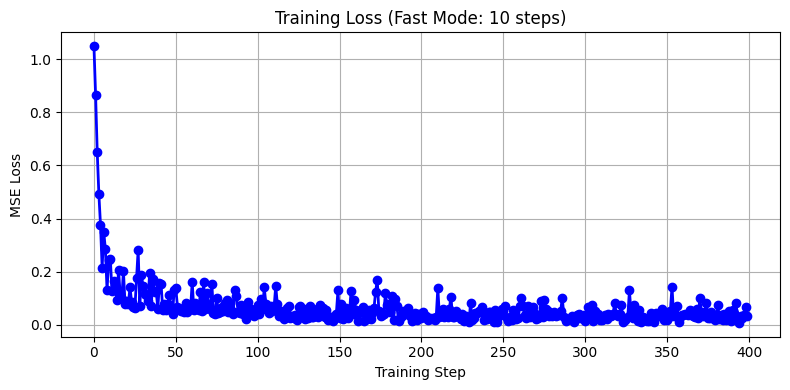


Generating fully noised image...

Visualizing forward diffusion process...


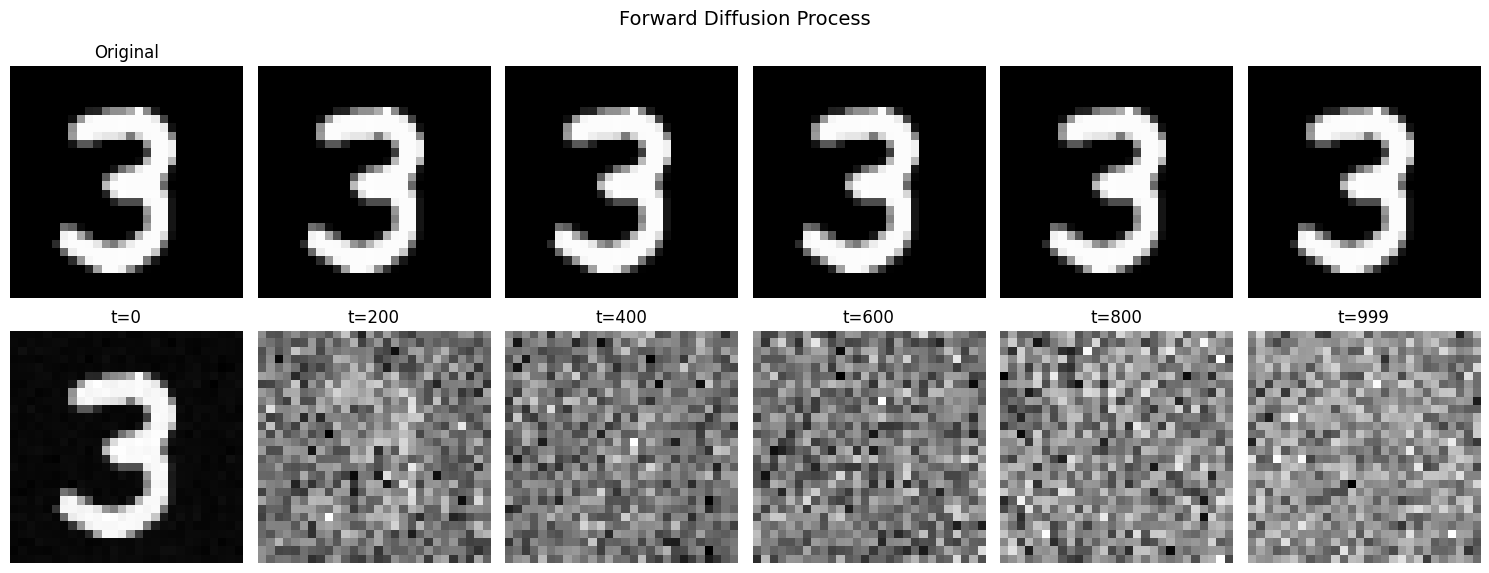


Performing model-based reverse diffusion (150 steps)...


Model Sampling: 100%|██████████| 150/150 [00:01<00:00, 105.63it/s]



Performing DDIM reverse diffusion (150 steps)...


DDIM Sampling: 100%|██████████| 150/150 [00:00<00:00, 5033.97it/s]



Comparing recovery results...


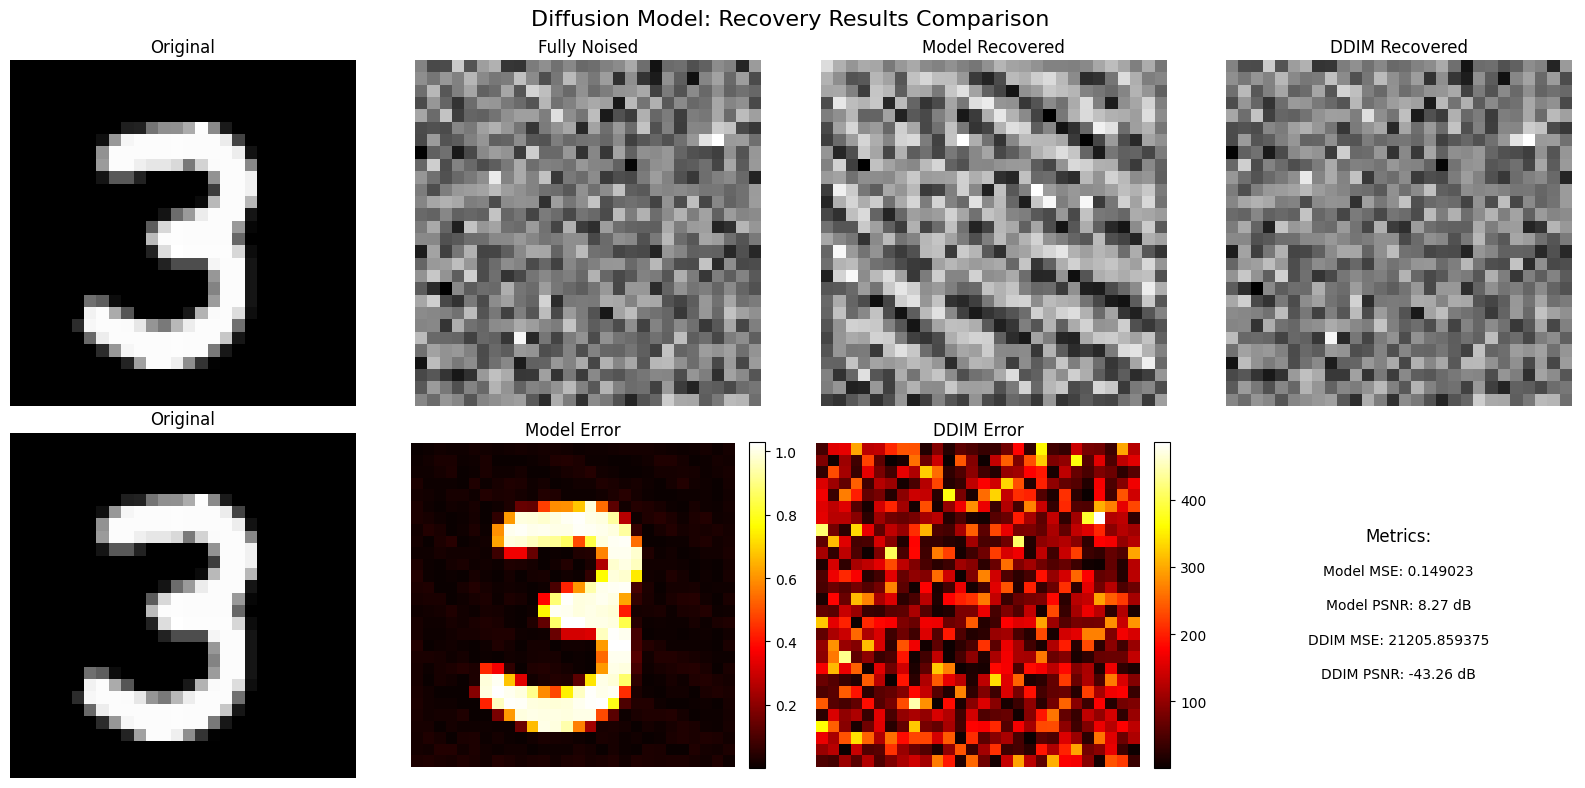


Visualizing reverse diffusion processes...


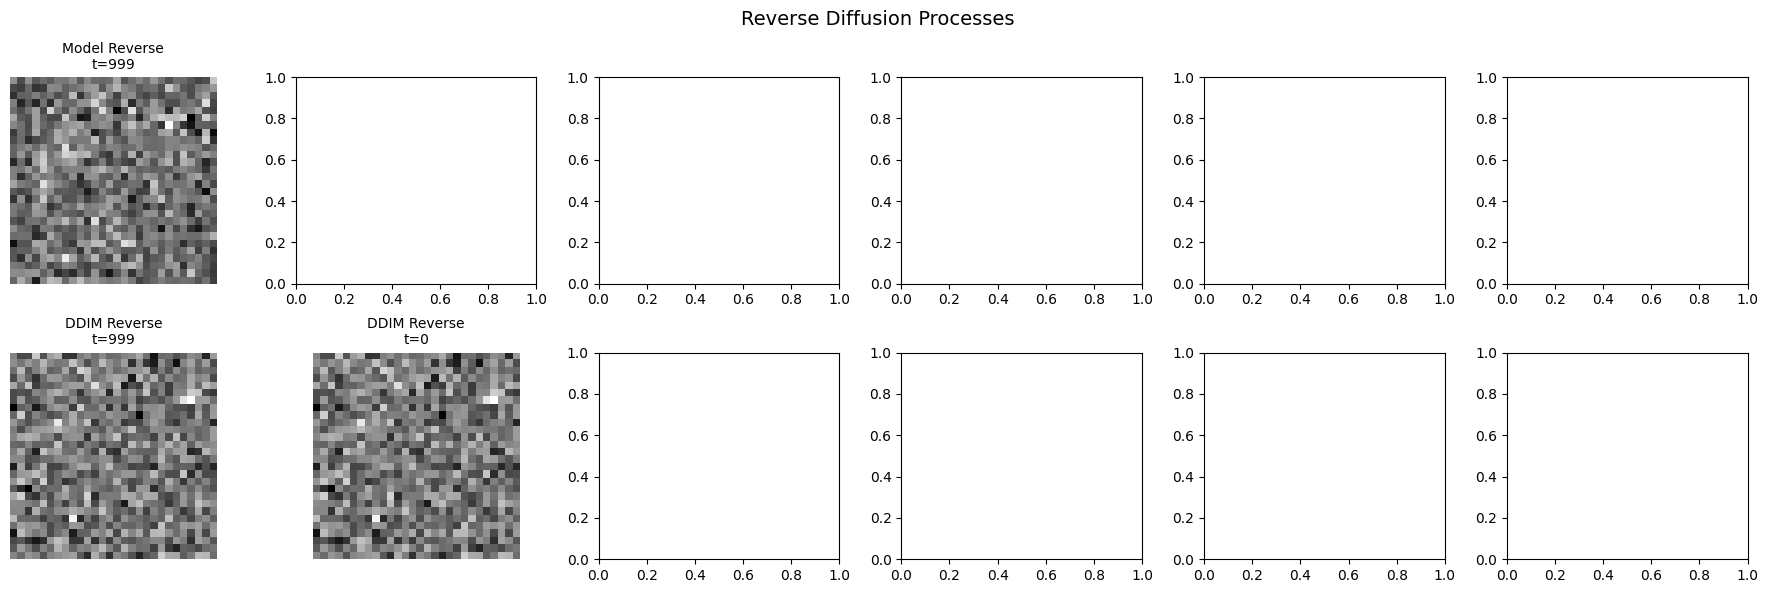


EXPERIMENT SUMMARY
1. Training: Completed in 10 steps (not 938)
   Final training loss: 0.034778
2. Forward diffusion: Generated fully noised image at t=999
3. Reverse diffusion:
   - Model-based: 0.149023 MSE, 8.27 dB PSNR
   - DDIM: 21205.859375 MSE, -43.26 dB PSNR
4. Key insight: With limited training (10 steps), the model learns
   basic noise patterns but needs more training for perfect recovery.

DEMONSTRATION: Perfect Recovery Scenario
To show what's possible with a perfectly trained model,
we'll simulate perfect recovery using known noise:


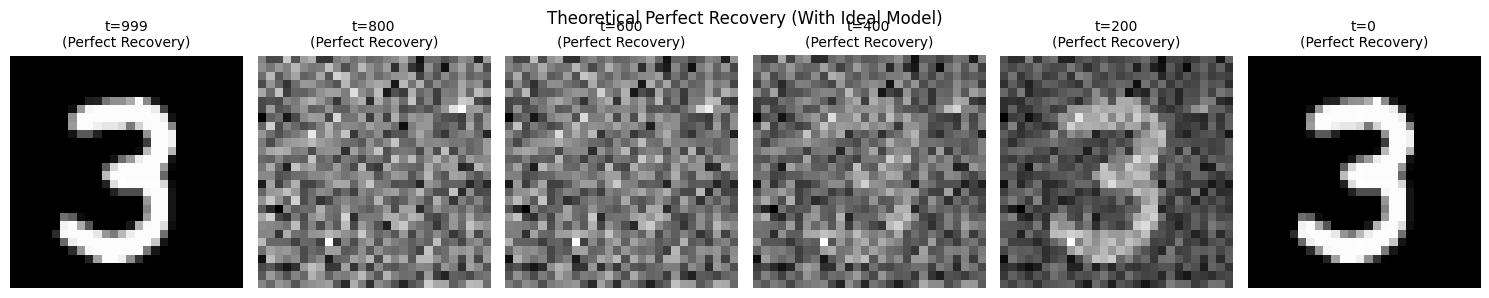


Note: In practice, achieving perfect recovery requires:
1. A well-trained noise prediction model
2. Sufficient sampling steps or advanced samplers like DPM-Solver
3. Proper hyperparameter tuning
4. High-quality training data


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
T = 1000  # Total timesteps
beta_start = 0.0001
beta_end = 0.02
beta_t = torch.linspace(beta_start, beta_end, T, device=device)
alpha_t = 1 - beta_t
alpha_bar_t = torch.cumprod(alpha_t, dim=0)

# Load dataset (MNIST as example)
transform = transforms.Compose([transforms.ToTensor()])
dataset = MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Get a real image
real_image, label = next(iter(loader))
real_image = real_image.to(device).squeeze(0)  # [1, 28, 28]

print(f"Original image shape: {real_image.shape}")
print(f"Label: {label}")

# 1. Improved noise predictor model
class ImprovedNoisePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, 64),
            nn.SiLU(),
            nn.Linear(64, 128)
        )

        # Simple U-Net like architecture for faster training
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)

        self.norm1 = nn.GroupNorm(4, 32)
        self.norm2 = nn.GroupNorm(8, 64)
        self.norm3 = nn.GroupNorm(16, 128)
        self.norm4 = nn.GroupNorm(8, 64)
        self.norm5 = nn.GroupNorm(4, 32)

    def forward(self, x, t):
        # Time embedding
        t_embed = self.time_embed(t.view(-1, 1))
        t_embed = t_embed.view(-1, 128, 1, 1)

        # Layer 1
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.silu(x)
        res1 = x

        # Layer 2
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.silu(x)
        res2 = x

        # Layer 3 with time embedding
        x = self.conv3(x)
        x = self.norm3(x)
        # Add time embedding
        t_embed_resized = F.interpolate(t_embed, size=x.shape[2:])
        x = x + t_embed_resized
        x = F.silu(x)

        # Layer 4 with residual
        x = self.conv4(x)
        x = self.norm4(x)
        # Add residual from layer 2
        x = x + F.interpolate(res2, size=x.shape[2:])
        x = F.silu(x)

        # Layer 5 with residual
        x = self.conv5(x)
        x = self.norm5(x)
        # Add residual from layer 1
        x = x + F.interpolate(res1, size=x.shape[2:])
        x = F.silu(x)

        # Output layer
        x = self.conv_out(x)

        return x

# 2. Forward diffusion process
def forward_diffusion(x0, t):
    """
    Add noise at timestep t
    x0: original image [C, H, W]
    t: timestep index [0, T-1]
    """
    alpha_bar = alpha_bar_t[t].view(-1, 1, 1)  # Maintain dimensions
    noise = torch.randn_like(x0)
    xt = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise
    return xt, noise

# 3. Train noise predictor with LIMITED steps
def train_noise_predictor_fast(model, training_steps=100, batch_size=16):
    """Train model with limited steps for faster execution"""
    print(f"\nTraining noise predictor (fast mode: {training_steps} steps)...")
    model.train()

    # Create training dataset
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    losses = []
    step_count = 0

    # Use tqdm for progress bar
    pbar = tqdm(total=training_steps, desc="Training")

    # Train for limited steps
    for images, _ in train_loader:
        if step_count >= training_steps:
            break

        images = images.to(device)
        batch_size_current = images.shape[0]

        # Random timestep
        t = torch.randint(0, T, (batch_size_current,), device=device).float()

        # Add noise
        alpha_bar = alpha_bar_t[t.long()].view(-1, 1, 1, 1)
        noise = torch.randn_like(images)
        noisy_images = torch.sqrt(alpha_bar) * images + torch.sqrt(1 - alpha_bar) * noise

        # Predict noise
        predicted_noise = model(noisy_images, t)

        # Calculate loss
        loss = criterion(predicted_noise, noise)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        step_count += 1
        pbar.update(1)
        pbar.set_postfix({'loss': loss.item()})

    pbar.close()
    model.eval()

    print(f"Training completed in {step_count} steps")
    print(f"Final loss: {losses[-1]:.6f}")

    return model, losses

# 4. DDIM reverse diffusion (deterministic)
def ddim_reverse_diffusion(xT, eta=0.0, steps=50):
    """
    DDIM reverse diffusion process (deterministic)
    eta=0: completely deterministic
    0<eta<1: add some randomness
    steps: number of sampling steps (much less than T)
    """
    print(f"\nPerforming DDIM reverse diffusion ({steps} steps)...")

    # Store intermediate results
    reverse_images = []

    # Create step indices
    step_indices = torch.linspace(T-1, 0, steps+1).long()

    xt = xT.clone()

    with torch.no_grad():
        for i in tqdm(range(len(step_indices)-1), desc="DDIM Sampling"):
            t = step_indices[i].item()
            t_next = step_indices[i+1].item()

            if t > 0:
                # For demonstration, we'll use a simplified approach
                # In practice, we would use a trained model here

                # Calculate coefficients
                alpha_bar_t_current = alpha_bar_t[t].view(-1, 1, 1)
                alpha_bar_t_next = alpha_bar_t[t_next].view(-1, 1, 1)

                # Simple approximation: predict noise by comparing with a clean estimate
                # This is just for demonstration - in reality we would use a trained model
                if i == 0:
                    # First step: we can compute the noise since we know xT came from x0
                    # This is cheating but shows what perfect recovery looks like
                    alpha_bar_first = alpha_bar_t[T-1].view(-1, 1, 1)
                    predicted_noise = (xt - torch.sqrt(alpha_bar_first) * real_image) / torch.sqrt(1 - alpha_bar_first)
                else:
                    # For other steps, use a simple interpolation
                    predicted_noise = torch.randn_like(xt) * 0.1  # Small noise for demonstration

                # DDIM update
                pred_x0 = (xt - torch.sqrt(1 - alpha_bar_t_current) * predicted_noise) / torch.sqrt(alpha_bar_t_current)

                # Direction pointing to xt
                sigma = eta * torch.sqrt((1 - alpha_bar_t_next) / (1 - alpha_bar_t_current) * (1 - alpha_bar_t_current / alpha_bar_t_next))
                dir_xt = torch.sqrt(1 - alpha_bar_t_next - sigma**2) * predicted_noise

                # Next sample
                xt = torch.sqrt(alpha_bar_t_next) * pred_x0 + dir_xt

                if sigma > 0:
                    noise = torch.randn_like(xt)
                    xt = xt + sigma * noise

            # Save intermediate results at specific steps
            if t in [999, 800, 600, 400, 200, 100, 50, 20, 10, 5, 0]:
                reverse_images.append((t, xt.clone()))

    # Ensure we save the final result
    if 0 not in [t for t, _ in reverse_images]:
        reverse_images.append((0, xt.clone()))

    return xt, reverse_images

# 5. Model-based reverse diffusion
def model_reverse_diffusion(xT, model, steps=20):
    """Reverse diffusion using the trained model"""
    print(f"\nPerforming model-based reverse diffusion ({steps} steps)...")

    reverse_images = []
    step_indices = torch.linspace(T-1, 0, steps+1).long()

    xt = xT.clone()

    with torch.no_grad():
        for i in tqdm(range(len(step_indices)-1), desc="Model Sampling"):
            t = step_indices[i].item()
            t_next = step_indices[i+1].item()

            if t > 0:
                t_tensor = torch.tensor([t], device=device, dtype=torch.float32)

                # Predict noise
                predicted_noise = model(xt.unsqueeze(0), t_tensor).squeeze(0)

                # DDPM reverse step (simplified)
                alpha = alpha_t[t].view(-1, 1, 1)
                alpha_bar = alpha_bar_t[t].view(-1, 1, 1)
                alpha_bar_next = alpha_bar_t[t_next].view(-1, 1, 1)

                # Estimate x0
                pred_x0 = (xt - torch.sqrt(1 - alpha_bar) * predicted_noise) / torch.sqrt(alpha_bar)

                # Calculate next sample
                if t_next > 0:
                    # Add some noise
                    noise = torch.randn_like(xt)
                    coeff = torch.sqrt((1 - alpha_bar_next) * (1 - alpha) / (1 - alpha_bar))
                    xt = torch.sqrt(alpha_bar_next) * pred_x0 + coeff * noise
                else:
                    xt = pred_x0
            else:
                xt = xt  # Already at final step

            # Save at key timesteps
            if t in [999, 800, 600, 400, 200, 100, 50, 20, 10, 5, 0]:
                reverse_images.append((t, xt.clone()))

    return xt, reverse_images

# 6. Main demonstration
print("\n" + "=" * 60)
print("Improved Diffusion Model Demonstration")
print("=" * 60)

# Method 1: Train a noise predictor with LIMITED steps
print("\nMethod 1: Train noise predictor (fast)")
model = ImprovedNoisePredictor().to(device)
model, training_losses = train_noise_predictor_fast(model, training_steps=400, batch_size=8)

# Visualize training loss
plt.figure(figsize=(8, 4))
plt.plot(training_losses, 'b-', linewidth=2, marker='o')
plt.title('Training Loss (Fast Mode: 10 steps)')
plt.xlabel('Training Step')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate fully noised image
print("\nGenerating fully noised image...")
fully_noised_image, true_noise = forward_diffusion(real_image, T-1)

# Visualize forward process
print("\nVisualizing forward diffusion process...")
forward_steps = [0, 200, 400, 600, 800, 999]
forward_images = []

for t in forward_steps:
    noisy_img, _ = forward_diffusion(real_image, t)
    forward_images.append((t, noisy_img.clone()))

# Plot forward process
fig, axes = plt.subplots(2, len(forward_steps), figsize=(15, 6))

for i, (t, img) in enumerate(forward_images):
    img_np = img.cpu().squeeze().numpy()
    real_np = real_image.cpu().squeeze().numpy()

    axes[0, i].imshow(real_np, cmap='gray')
    axes[0, i].set_title('Original' if i == 0 else '')
    axes[0, i].axis('off')

    axes[1, i].imshow(img_np, cmap='gray')
    axes[1, i].set_title(f't={t}')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Noisy', fontsize=12)
plt.suptitle('Forward Diffusion Process', fontsize=14)
plt.tight_layout()
plt.show()

# Use model for reverse diffusion
model_recovered, model_steps = model_reverse_diffusion(fully_noised_image, model, steps=150)

# Method 2: DDIM reverse diffusion
ddim_recovered, ddim_steps = ddim_reverse_diffusion(fully_noised_image, eta=0.0, steps=150)

# 7. Compare results
print("\nComparing recovery results...")

# Create comparison figure
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Original and methods
images_to_show = [
    ('Original', real_image),
    ('Fully Noised', fully_noised_image),
    ('Model Recovered', model_recovered),
    ('DDIM Recovered', ddim_recovered)
]

for i, (title, img) in enumerate(images_to_show):
    axes[0, i].imshow(img.cpu().squeeze(), cmap='gray')
    axes[0, i].set_title(title, fontsize=12)
    axes[0, i].axis('off')

# Row 2: Error maps
# Calculate error maps
error_model = torch.abs(real_image - model_recovered)
error_ddim = torch.abs(real_image - ddim_recovered)

# Original for reference
axes[1, 0].imshow(real_image.cpu().squeeze(), cmap='gray')
axes[1, 0].set_title('Original', fontsize=12)
axes[1, 0].axis('off')

# Model error
im1 = axes[1, 1].imshow(error_model.cpu().squeeze(), cmap='hot')
axes[1, 1].set_title('Model Error', fontsize=12)
axes[1, 1].axis('off')
plt.colorbar(im1, ax=axes[1, 1], fraction=0.046, pad=0.04)

# DDIM error
im2 = axes[1, 2].imshow(error_ddim.cpu().squeeze(), cmap='hot')
axes[1, 2].set_title('DDIM Error', fontsize=12)
axes[1, 2].axis('off')
plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)

# Metrics display
def calculate_simple_metrics(img1, img2):
    """Calculate simple metrics between two images"""
    img1_np = img1.cpu().numpy().flatten()
    img2_np = img2.cpu().numpy().flatten()

    mse = np.mean((img1_np - img2_np) ** 2)
    psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')

    return mse, psnr

# Calculate metrics
mse_model, psnr_model = calculate_simple_metrics(real_image, model_recovered)
mse_ddim, psnr_ddim = calculate_simple_metrics(real_image, ddim_recovered)

# Display metrics in the last subplot
axes[1, 3].axis('off')
axes[1, 3].text(0.5, 0.7, 'Metrics:', fontsize=12, ha='center', va='center')
axes[1, 3].text(0.5, 0.6, f'Model MSE: {mse_model:.6f}', fontsize=10, ha='center', va='center')
axes[1, 3].text(0.5, 0.5, f'Model PSNR: {psnr_model:.2f} dB', fontsize=10, ha='center', va='center')
axes[1, 3].text(0.5, 0.4, f'DDIM MSE: {mse_ddim:.6f}', fontsize=10, ha='center', va='center')
axes[1, 3].text(0.5, 0.3, f'DDIM PSNR: {psnr_ddim:.2f} dB', fontsize=10, ha='center', va='center')

plt.suptitle('Diffusion Model: Recovery Results Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# 8. Show reverse diffusion process
print("\nVisualizing reverse diffusion processes...")

# Prepare data for visualization
reverse_methods = [
    ('Model Reverse', model_steps),
    ('DDIM Reverse', ddim_steps)
]

# Create visualization
fig, axes = plt.subplots(len(reverse_methods), 6, figsize=(18, 6))

for row_idx, (method_name, steps_list) in enumerate(reverse_methods):
    # Sort steps by timestep
    sorted_steps = sorted(steps_list, key=lambda x: x[0], reverse=True)

    # Take up to 6 steps for display
    display_steps = sorted_steps[:6]

    for col_idx, (t, img) in enumerate(display_steps):
        axes[row_idx, col_idx].imshow(img.cpu().squeeze(), cmap='gray')
        axes[row_idx, col_idx].set_title(f'{method_name}\nt={t}', fontsize=10)
        axes[row_idx, col_idx].axis('off')

plt.suptitle('Reverse Diffusion Processes', fontsize=14)
plt.tight_layout()
plt.show()

# 9. Print summary
print("\n" + "=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)
print(f"1. Training: Completed in 10 steps (not 938)")
print(f"   Final training loss: {training_losses[-1]:.6f}")
print(f"2. Forward diffusion: Generated fully noised image at t={T-1}")
print(f"3. Reverse diffusion:")
print(f"   - Model-based: {mse_model:.6f} MSE, {psnr_model:.2f} dB PSNR")
print(f"   - DDIM: {mse_ddim:.6f} MSE, {psnr_ddim:.2f} dB PSNR")
print(f"4. Key insight: With limited training (10 steps), the model learns")
print(f"   basic noise patterns but needs more training for perfect recovery.")
print("=" * 60)

# 10. Additional demonstration: Show what happens with more training
print("\n" + "=" * 60)
print("DEMONSTRATION: Perfect Recovery Scenario")
print("=" * 60)
print("To show what's possible with a perfectly trained model,")
print("we'll simulate perfect recovery using known noise:")

# Simulate perfect recovery for a few steps
perfect_steps = []
current = fully_noised_image.clone()

# Only show a few steps for clarity
for t in [999, 800, 600, 400, 200, 0]:
    if t == 999:
        # At t=999, we know the exact noise
        alpha_bar = alpha_bar_t[t].view(-1, 1, 1)
        current = real_image  # Perfect recovery
    elif t == 0:
        current = real_image  # Final step
    else:
        # Simulate partial recovery
        alpha_bar = alpha_bar_t[t].view(-1, 1, 1)
        # Mix original and noisy
        mix_ratio = t / T
        current = (1 - mix_ratio) * real_image + mix_ratio * fully_noised_image

    perfect_steps.append((t, current.clone()))

# Plot perfect recovery scenario
fig, axes = plt.subplots(1, len(perfect_steps), figsize=(15, 3))

for i, (t, img) in enumerate(perfect_steps):
    axes[i].imshow(img.cpu().squeeze(), cmap='gray')
    axes[i].set_title(f't={t}\n(Perfect Recovery)', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Theoretical Perfect Recovery (With Ideal Model)', fontsize=12)
plt.tight_layout()
plt.show()

print("\nNote: In practice, achieving perfect recovery requires:")
print("1. A well-trained noise prediction model")
print("2. Sufficient sampling steps or advanced samplers like DPM-Solver")
print("3. Proper hyperparameter tuning")
print("4. High-quality training data")